In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["NUMEXPR_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel

sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10.0, 10.0)

PCA Implementation

In [3]:
class PCA:
    def __init__(self, data, k):
        """
        PCA module will take two inputs:
        data: original data matrix with n*d numpy.ndarray where n is number of data and
              d is dimension of each data point.
        k: The dimension will be given after performing PCA.
        """
        self.data = self._normalization(data)
        self.cov = self._covariance()
        self.trans = self._trans(self.cov, k)
    def _normalization(self, data):
        """
        This function normalizes the data 
        """
        mean = np.mean(data, axis=0)
        # Unbias estimator
        # Avoid divide by zero problem
#         std = np.std(data, axis=0, ddof=1) + 10e-10
        return (data-mean)
    def _covariance(self):
        """
        This function takes normalized data as input,
        then output its covariance matrix.
        """
        return np.cov(self.data, rowvar=False) / self.data.shape[0]
    def _trans(self, cov, k):
        val, vec = np.linalg.eig(cov)
        # get index of k max eigenvalues
        idx = np.argsort(val)[-1: -(k+1): -1]
        return vec[:, idx]
    def transform(self):
        return self.data @ self.trans

Load training data

In [4]:
X_train = pd.read_csv('./data/X_train.csv', header=None)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0


In [5]:
T_train = pd.read_csv('./data/T_train.csv', header=None)
T_train.head()

,0
0,1
1,1
2,1
3,1
4,1


In [6]:
X_train_low = PCA(X_train.values, 2).transform().real
X_train_low.shape

(5000, 2)

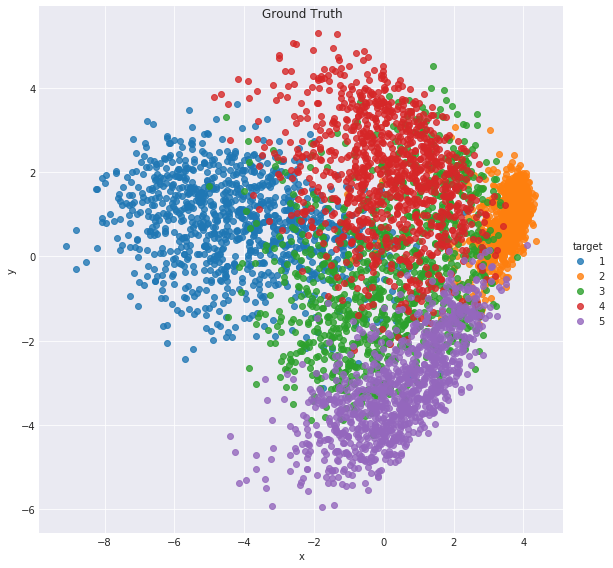

In [16]:
GT_df = pd.DataFrame(X_train_low, columns=['x', 'y'])
GT_df['target'] = T_train.values
plot = sns.lmplot(x='x', y='y', data=GT_df, fit_reg=False, hue='target', legend=True, size=8)
fig = plot.fig
fig.suptitle("Ground Truth", fontsize=12)
fig.savefig('./plot/{}.png'.format('GroundTruth'))

In [8]:
pca = PCA(X_train.values, 2)
print(pca.cov.shape)

(784, 784)


Ncut implementation

In [9]:
class NCut:
    def __init__(self, data, k, kernel_type):
        self.k = k
        W = self._similiar(data, kernel_type).astype('float32')
        D = self._degree(W).astype('float32')
        self.L_sym = self._laplacian(W, D).astype('float32')
#         print('finish L_sym')
#         U = self._eigenproblem(L_sym, k)
#         print('finish U')
#         self.T = self._normalize(U)
#         print('finish T')
        
    def _similiar(self, data, kernel_type):
        if kernel_type == 0:
            return linear_kernel(data)
        elif kernel_type == 1:
            return rbf_kernel(data, gamma=0.01)
        elif kernel_type == 2:
            return rbf_kernel(data, gamma=0.01) + linear_kernel(data)
        
    def _degree(self, W):
        return np.diag(np.sum(np.abs(W), axis=1))
    
    def _laplacian(self, W, D):
        D_square = np.diag(np.power(np.diag(D), -0.5))
        return np.eye(W.shape[0]) - D_square @ W @ D_square
    
    def _eigenproblem(self, L_sym, k):
        val, vec = np.linalg.eig(L_sym)
        idx = np.argsort(val)[1: k+1]
        return vec[:, idx]
    
    def _normalize(self, U):
        sum_over_row = (np.sum(np.power(U, 2), axis=1) ** 0.5).reshape(-1, 1)
        return U / sum_over_row
    
    def solve(self):
        U = self._eigenproblem(self.L_sym, self.k).real.astype('float32')
        T = self._normalize(U)
        return T

In [10]:
class KMeans:
    def __init__(self, dataset, k):
        self.dataset = dataset
        self.k = k
        self.num = dataset.shape[0]
        self.dim = dataset.shape[1]
    def _dist(self, x1, x2):
        return np.sum(np.power(x1 - x2, 2))
    def _center(self):
        centers = np.zeros((self.k, self.dim))
        s = set()
        for i in range(self.k):
            # Generate non-repeated index
            while True:
                index = int(np.random.uniform(0, self.num + 1))
                if index not in s:
                    s.add(index)
                    break
            centers[i, :] = self.dataset[index, :]
        return centers

    def fit(self, init_center=None):
        # cluster_mat store two information of each instance
        # First dim: which cluster the instance belongs to
        # Second dim: the distance between instance and center
        cluster_mat = np.mat(np.zeros((self.num, 2)))
        # Indicator of the loop
        cluster_flag = True
        # Randomly generate centers
        # centers = self._center()
        if init_center is None:
            centers = self._center()
        else:
            centers = init_center
        
        idx = 0
        while cluster_flag:
            cluster_flag = False
            # Assign points to corresponding centers based on distance
            for i in range(self.num):
                min_dist = float('inf')
                min_idx = -1
                for j in range(self.k):
                    dist = self._dist(centers[j, :], self.dataset[i, :])
                    if dist < min_dist:
                        min_dist = dist
                        min_idx = j
                if cluster_mat[i, 0] != min_idx:
                    cluster_flag = True
                    cluster_mat[i, :] = min_idx, min_dist
            
            # Update center of each clustering
            for j in range(self.k):
                cluster_points = self.dataset[np.nonzero(cluster_mat[:, 0].A == j)[0]]
                centers[j, :] = np.mean(cluster_points, axis=0)
            idx = idx+1
            if idx == 1000:
                cluster_flag = False
        return centers, cluster_mat

In [21]:
ncut = NCut(X_train.values, 5, 2)

In [22]:
T = ncut.solve()
print(T)

[[ 0.48714787  0.4767244   0.28731784  0.5745685   0.3503431 ]
 [ 0.45969203  0.5134216   0.3751263   0.57433563  0.23345324]
 [ 0.16070086  0.08222621  0.05090305  0.35587546  0.91551936]
 ...
 [ 0.4419156  -0.513716   -0.00967519  0.0194596  -0.73507434]
 [ 0.50188565 -0.68848807 -0.27125028  0.305813    0.32710338]
 [ 0.01252895 -0.839798   -0.27549964  0.39528626  0.24986213]]


In [23]:
_, lbl = KMeans(T, 5).fit()
print(lbl[:, 0])

[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [4.]
 [4.]]


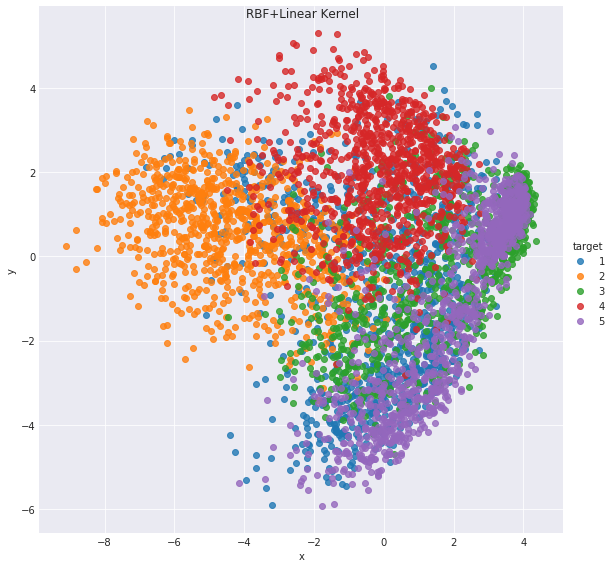

In [24]:
train_df = pd.DataFrame(X_train_low, columns=['x', 'y'])
train_df['target'] = lbl[:, 0].astype('int') + 1
plot = sns.lmplot(x='x', y='y', data=train_df, fit_reg=False, hue='target', legend=True, size=8)
fig = plot.fig
fig.suptitle("{} Kernel".format('RBF+Linear'), fontsize=12)
fig.savefig('./plot/{}.png'.format('rbf_linear_ncut'))

In [25]:
class RatioCut:
    def __init__(self, data, k, kernel_type):
        self.k = k
        W = self._similiar(data, kernel_type).astype('float32')
        D = self._degree(W).astype('float32')
        self.L = self._laplacian(W, D).astype('float32')
#         print('finish L_sym')
#         U = self._eigenproblem(L_sym, k)
#         print('finish U')
#         self.T = self._normalize(U)
#         print('finish T')
        
    def _similiar(self, data, kernel_type):
        if kernel_type == 0:
            return linear_kernel(data)
        elif kernel_type == 1:
            return rbf_kernel(data, gamma=0.01)
        elif kernel_type == 2:
            return rbf_kernel(data, gamma=0.01) + linear_kernel(data)
        
    def _degree(self, W):
        return np.diag(np.sum(np.abs(W), axis=1))
    
    def _laplacian(self, W, D):
        return D - W
    
    def _eigenproblem(self, L, k):
        val, vec = np.linalg.eig(L)
        idx = np.argsort(val)[1: k+1]
        return vec[:, idx]
    
    def solve(self):
        U = self._eigenproblem(self.L, self.k).real.astype('float32')
        return U

In [40]:
rcut = RatioCut(X_train.values, 5, 2)

In [41]:
U = rcut.solve()
print(U)

[[-0.0002162  -0.00022597  0.00021427  0.00023019  0.00023156]
 [-0.00020723 -0.00021367  0.00020721  0.00021479  0.00021517]
 [-0.00018868 -0.000193    0.00018414  0.00020315  0.00018907]
 ...
 [-0.00027547 -0.00027911  0.00024984  0.0002864   0.00029833]
 [-0.0002593  -0.00022783  0.00016617  0.00026485  0.00029865]
 [-0.00017987 -0.0001773   0.00017259  0.00018613  0.0001908 ]]


In [44]:
_, lbl = KMeans(U, 5).fit()
print(lbl[:, 0])

[[2.]
 [2.]
 [2.]
 ...
 [3.]
 [3.]
 [2.]]


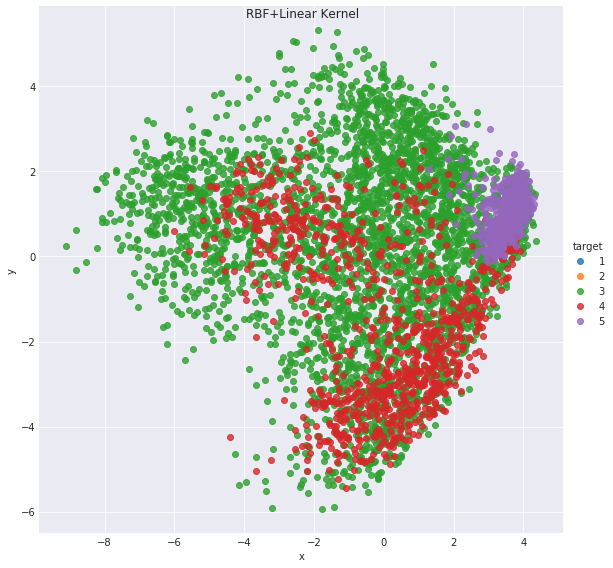

In [45]:
train_df = pd.DataFrame(X_train_low, columns=['x', 'y'])
train_df['target'] = lbl[:, 0].astype('int') + 1
plot = sns.lmplot(x='x', y='y', data=train_df, fit_reg=False, hue='target', legend=True, size=8)
fig = plot.fig
fig.suptitle("{} Kernel".format('RBF+Linear'), fontsize=12)
fig.savefig('./plot/{}.png'.format('rbf_linear_rcut'))